In [115]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
import torch.nn as nn
import cv2

In [2]:
# Get Test Set 
# !wget https://www2.seas.gwu.edu/~astylianou/hotels50k/test.tar.gz

# Formatting Data 
The available metadata is...
* Hotel Chain Name (93, including an 'unkown')
* Hotel Name (50,000) with associative Hotel Chain 
* Hotel Latitude and Longitude
* Image Datasource (travel_website and TraffickCam)
* People Crops (6,486)

In [109]:
t = Path('Hotels-50K/images/train/')
c = Path('Hotels-50K/images/people_crops/')

In [110]:
# images/train/chain_id/hotel_id/data_source/image_id.jpg
def extract_train(limit=False):
    data = []
    i = 0
    for chain_id in t.ls():
        for hotel_id in chain_id.ls():
            for d_source in hotel_id.ls():
                for image_id in d_source.ls():
                    i += 1
                    data.append([chain_id.name, 
                                 hotel_id.name, 
                                 d_source.name, 
                                 image_id.name,
                                 str(image_id)])
                    if limit and i > 200:
                        return data

def extract_occlusions(limit=False):
    data, i = [], 0
    for c in crops.ls():
        i += 1
        data.append([c.name,
                    str(c)])
        if limit and i > 200:
            return data

In [111]:
data = extract_train(limit=True)
occ = extract_occlusions(limit=True)

In [112]:
data_df = pd.DataFrame(data, columns=['chain_id',
                              'hotel_id',
                              'd_source',
                              'image_id',
                              'path'])
occ_df = pd.DataFrame(occ, columns=['occlusion_id', 'path'])
# df.to_csv(...) save + package for cloud

In [137]:
data_df.head()

,chain_id,hotel_id,d_source,image_id,path
0,61,49863,travel_website,1123686.jpg,Hotels-50K/images/train/61/49863/travel_websit...
1,61,49863,travel_website,1123684.jpg,Hotels-50K/images/train/61/49863/travel_websit...
2,61,49863,travel_website,1123685.jpg,Hotels-50K/images/train/61/49863/travel_websit...
3,61,49863,travel_website,1123682.jpg,Hotels-50K/images/train/61/49863/travel_websit...
4,61,49863,travel_website,1123683.jpg,Hotels-50K/images/train/61/49863/travel_websit...


In [114]:
occ_df.head()

,occlusion_id,path
0,8820.png,Hotels-50K/images/people_crops/8820.png
1,14392.png,Hotels-50K/images/people_crops/14392.png
2,348.png,Hotels-50K/images/people_crops/348.png
3,25629.png,Hotels-50K/images/people_crops/25629.png
4,29013.png,Hotels-50K/images/people_crops/29013.png


## Creating Data Bunch

In [124]:
# apply occlusions to training images
def _occlusion(x):
    if np.random.uniform() < 0.5:
        # TODO: optimize for faster imread + uniform sampling across crops
        idx = np.random.randint(len(occ_df)-1)
        img_path = occ_df.loc[idx]['path']
        img = cv2.imread(img_path)
        
        # TODO: apply mask onto image
        
        # ...test it works...
        x += torch.rand(x.shape)
    return x
occlusion = TfmPixel(_occlusion)

In [133]:
batch_size = 10
img_size = 224
ds_tfms = get_transforms(xtra_tfms=[occlusion()])
label_col = 1 # hotel_id


# If the class has only 1 image, we want it to be in the train-set.
# TODO Fix: https://forums.fast.ai/t/kaggle-humpback-whale-identification/35934
data = ImageDataBunch.from_df('.', 
                              df, 
                              label_col=label_col,
                              fn_col=-1, 
                              ds_tfms=ds_tfms, 
                              size=img_size,
                              bs=batch_size)

/Users/brennangebotys/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
20454
  if getattr(ds, 'warn', False): warn(ds.warn)


# View Data

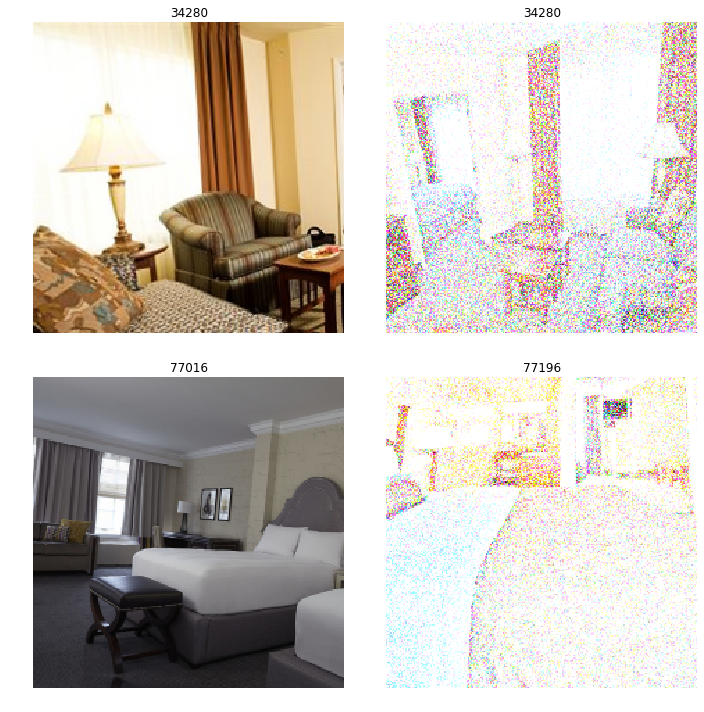

In [126]:
data.show_batch(rows=2, figsize=(10, 10))

# Training 

In [127]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [138]:
learn.fit_one_cycle(1)